# Module: Dust attenuation

> Adding dust attenuation based on DustE modelling

In [ ]:
#| default_exp dust_attenuation

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import numpy as np

In [ ]:
#| hide
import matplotlib.pylab as plt

In [ ]:
#| export
from watercolor.load_sim_stellar_catalog import load_hacc_galaxy_data
from watercolor.calculate_csp import calc_fluxes_for_galaxy
from watercolor.load_sps_library import STELLAR_LIBRARY_DIR

In [ ]:
#| hide 
galaxy_star_catalog_file = '../watercolor/data/test_hacc_stellar_catalog/Gals_Z0.txt'
galaxy_tags, stellar_idx, metal_hydro, mass, age_hydro, _, _, _, _, _, _ = load_hacc_galaxy_data(galaxy_star_catalog_file)

In [ ]:
# galaxy_star_catalog_file = '../hydro_colors/data/test_hacc_stellar_catalog/Gals_Z0.txt'
# galaxy_star_catalog_file = '../hydro_colors/data/test_hacc_stellar_catalog/Gals_Z0_576.txt'

# np.loadtxt(galaxy_star_catalog_file, skiprows=1, unpack=True).shape

In [ ]:
#| hide 

galaxy_number = 4
unique_galaxy_tag = np.unique(galaxy_tags)[galaxy_number]

spec_wave_ssp, spec_flux_ssp, spec_csp, flux_proxy, gal_stellar_mass = calc_fluxes_for_galaxy(galaxy_star_catalog_file,
                                                                                                               unique_galaxy_tag,
                                                                                                               STELLAR_LIBRARY_DIR)

Library shape:  (22, 94, 1963)
Wavelength shape:  (1963,)


In [ ]:
#| export

import sys
import os
from duste.DustAttnCalc import DustAttnCalc # https://github.com/Astropianist/DustE

In [ ]:
#| hide

import astropy.units as u
from astropy.cosmology import Planck13, z_at_value
z_at_value(Planck13.age, 2 * u.Gyr) 

<Quantity 3.19812061 redshift>

(array([ 6.,  4., 11.,  5.,  2.,  4.,  4.,  2.,  2.,  1.]),
 array([0.03835494, 0.91050649, 1.78265803, 2.65480958, 3.52696113,
        4.39911267, 5.27126422, 6.14341577, 7.01556732, 7.88771886,
        8.75987041]),
 <BarContainer object of 10 artists>)

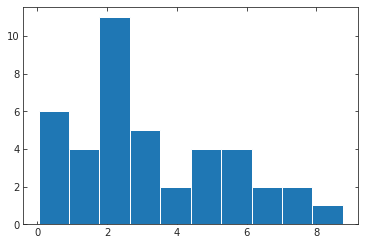

In [ ]:
#| hide

plt.hist(age_hydro[galaxy_tags == unique_galaxy_tag])

In [ ]:
#| hide

# Disable
def blockPrint():
    sys._jupyter_stdout = sys.stdout
    sys.stdout = open(os.devnull, 'w')

# Restore
def enablePrint():
    sys._jupyter_stdout = sys.stdout
    sys.stdout = sys.__stdout__


def colors_dusted(pcolor, wave, logmstar, metal, redshift):
     
    blockPrint()
    
    dust_attn = DustAttnCalc(logM=logmstar, 
                             # sfr=SFRz, 
                             logZ=metal, 
                             z = redshift, 
                             bv=1, eff=0, wv_arr=wave); # Two-component bivariate dust model (fitting both optical depth and slope) 

    dac, dac1, n, tau, tau1, n_err, tau_err, tau1_err = dust_attn.calcDust(plot_tau=False, max_num_plot=2);
    dac_avg, dac1_avg = np.average(dac, axis=0), np.average(dac1, axis=0)
    dust_ext_fac0 = np.exp(-1*dac_avg)*np.exp(-1*dac1_avg) #correct
    pcolor_attn = pcolor*dust_ext_fac0[0, :];
    
    enablePrint()
    return pcolor_attn
    

In [ ]:
#| hide

logmstar = np.array([np.log10( np.sum(mass[galaxy_tags == unique_galaxy_tag]))])
logZ = np.array([np.sum(metal_hydro[galaxy_tags == unique_galaxy_tag])])


spec_wave_csp_dusted = colors_dusted(spec_csp, spec_wave_ssp, logmstar, logZ, 0.001)

<matplotlib.legend.Legend>

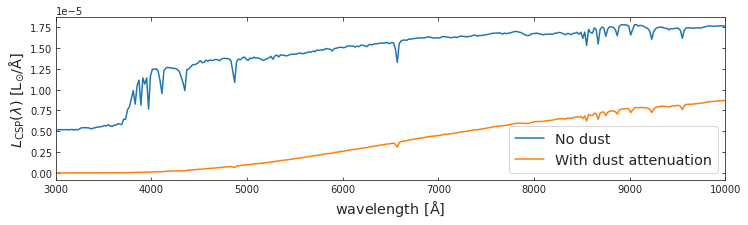

In [ ]:
#| hide 

f, a = plt.subplots(1, 1, figsize=(12, 3))
a.plot(spec_wave_ssp, spec_csp, label='No dust')
a.plot(spec_wave_ssp, spec_wave_csp_dusted, label='With dust attenuation')



a.set_xlim(3e3, 1e4)

a.set_xlabel(r'${\rm wavelength\ [\AA]}$', fontsize = 'x-large')
a.set_ylabel(r'$L_{\rm CSP}(\lambda)\ {\rm [L_{\odot}/\AA]}$', fontsize = 'x-large')
a.legend(fontsize='x-large')

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()